<a href="https://colab.research.google.com/github/kavyajeetbora/monitoring_water_surface_area/blob/master/notebooks/estimating_lake_depth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimating the lake depth

Citations

1. Khazaei, Bahram; Read, Laura K; Casali, Matthew; Sampson, Kevin M; Yates, David N (2022): GLOBathy Bathymetry Rasters. figshare.
Dataset. https://doi.org/10.6084/m9.figshare.13404635.v1

In [1]:
!pip install -q xee
!pip install -q rioxarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 39.3 MB/s eta 0:00:00


In [67]:
import geemap
import ee
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
from IPython.display import Image as IpyImage
from PIL import Image, ImageFont, ImageDraw, ImageSequence
import xarray as xr
import rioxarray as rxr
import numpy as np
from matplotlib import cm, animation
import plotly.graph_objects as go

ee.Authenticate()
ee.Initialize(project='kavyajeetbora-ee')

## Area of Interest

Used this tool to create a geojson file of the area of interest:

[keene Polyline Tool](https://www.keene.edu/campus/maps/tool/?coordinates=77.1200409%2C%2011.5324541%0A76.9923248%2C%2011.5062217%0A76.9916382%2C%2011.3467571%0A77.1529998%2C%2011.4261642%0A77.1200409%2C%2011.5324541) : Use this tool to create a polygon and generate a GeoJson text for further use

In [3]:
geojson  = {
  "coordinates": [
    [
      [
        91.6080666,
        26.1289069
      ],
      [
        91.6017151,
        26.1178869
      ],
      [
        91.605835,
        26.1113361
      ],
      [
        91.6094399,
        26.104939
      ],
      [
        91.6166496,
        26.0986958
      ],
      [
        91.6305542,
        26.0963063
      ],
      [
        91.647377,
        26.0959209
      ],
      [
        91.6672897,
        26.0969229
      ],
      [
        91.6842842,
        26.1057098
      ],
      [
        91.6823959,
        26.1131858
      ],
      [
        91.6829109,
        26.1273657
      ],
      [
        91.6760445,
        26.1385389
      ],
      [
        91.6666031,
        26.1425456
      ],
      [
        91.65802,
        26.1484013
      ],
      [
        91.6423988,
        26.1467062
      ],
      [
        91.6303825,
        26.1430079
      ],
      [
        91.6080666,
        26.1289069
      ],
      [
        91.6080666,
        26.1289069
      ]
    ]
  ],
  "type": "Polygon"
}

geometry = ee.Geometry(geojson)

## Downloading the Global Surface Water data

[JRC Global Surface Water Data](https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_4_YearlyHistory): This dataset contains maps of the location and temporal distribution of surface water from 1984 to 2021 and provides statistics on the extent and change of those water surfaces

This dataset has a waterClass property that classifies a pixel whether it is a surface water or not. It has 4 classes:

|Value|Color|Description|
|-----|------|-------------|
|0|#cccccc|No data|
|1|#ffffff|Not water|
|2|#99d9ea|Seasonal water|
|3|#0000ff|Permanent water|

For this case, to classify a pixel to be water, we will consider class 2 or 3 to be as water and rest of the pixel we can mask them as `nodata`

In [4]:
globathy = ee.Image("projects/sat-io/open-datasets/GLOBathy/GLOBathy_bathymetry")
globathy = globathy.multiply(-1).rename('DSM').unmask(0) ## Multiplying -1 to represent the data in negative

Map = geemap.Map(basemap='OpenTopoMap')
visParams = {"min": -20, "max": 0, 'palette': ['#d73027','#f46d43','#fdae61','#fee090','#e0f3f8','#abd9e9','#74add1','#4575b4']}
Map.addLayer(globathy.clip(geometry), visParams, 'Global Bathymetry')
Map.centerObject(geometry, zoom=12)
Map

Map(center=[26.11995420853361, 91.64530222585796], controls=(WidgetControl(options=['position', 'transparent_b…

## Load the elevation model

[All you need to know about digital elevation models](https://up42.com/blog/everything-you-need-to-know-about-digital-elevation-models-dem-digital)

In [5]:
alos_dsm = ee.ImageCollection("JAXA/ALOS/AW3D30/V3_2")\
.filter(ee.Filter.bounds(geometry))

alos_image = alos_dsm.first().select("DSM")

## Add the two images
terrain = alos_image.add(globathy)
terrain

In [6]:
Map = geemap.Map(basemap='OpenTopoMap')
palette = ['#543005','#8c510a','#bf812d','#dfc27d','#f6e8c3','#c7eae5','#80cdc1','#35978f','#01665e','#003c30']
visParams = {"bands": ['DSM'], "min": 0, "max": 500, 'palette': palette}

Map.addLayer(terrain.clip(geometry), visParams, 'ALOS Global DSM-30m')
# Map.addLayer(geometry, {}, "boundary")
Map.centerObject(geometry, zoom=12)
Map

Map(center=[26.11995420853361, 91.64530222585796], controls=(WidgetControl(options=['position', 'transparent_b…

In [90]:
gaussianFilter = ee.Kernel.gaussian(radius=50, sigma=100, units='pixels', normalize=True)
# Apply Gaussian smoothing to the elevation data
smoothed_elevation = alos_image.convolve(gaussianFilter)

In [91]:
Map = geemap.Map(basemap='OpenTopoMap')
palette = ['#543005','#8c510a','#bf812d','#dfc27d','#f6e8c3','#c7eae5','#80cdc1','#35978f','#01665e','#003c30']
visParams = {"bands": ['DSM'], "min": 0, "max": 500, 'palette': palette}

Map.addLayer(smoothed_elevation.clip(geometry), visParams, 'ALOS Global DSM-30m')
Map.centerObject(geometry, zoom=12)
Map

Map(center=[26.11995420853361, 91.64530222585796], controls=(WidgetControl(options=['position', 'transparent_b…

## Convert ee.Image to xarray

Fix this issue:

Using `geemap.ee_to_xarray`:

[Converting Earth Engine dataset into XArray #1942](https://github.com/gee-community/geemap/discussions/1942)

ee.Image is getting converted to the xrray but the values are converted as null values.

In [87]:
geemap.ee_export_image

<function geemap.common.ee_export_image(ee_object, filename, scale=None, crs=None, crs_transform=None, region=None, dimensions=None, file_per_band=False, format='ZIPPED_GEO_TIFF', unzip=True, unmask_value=None, timeout=300, proxies=None)>

In [92]:
projFromWKT = ee.Projection(
    '''PROJCS["WGS 84 / UTM zone 46N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32646"]]'''
)
projFromWKT

In [94]:
geemap.ee_export_image(
    terrain.reproject(projFromWKT), filename="terrain.tif", scale=30, region=geometry, file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to /content/terrain.tif


In [98]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from osgeo import gdal
import matplotlib.pyplot as plt
import scipy as sp
import scipy.ndimage
from PIL import Image
import matplotlib.cm as cm

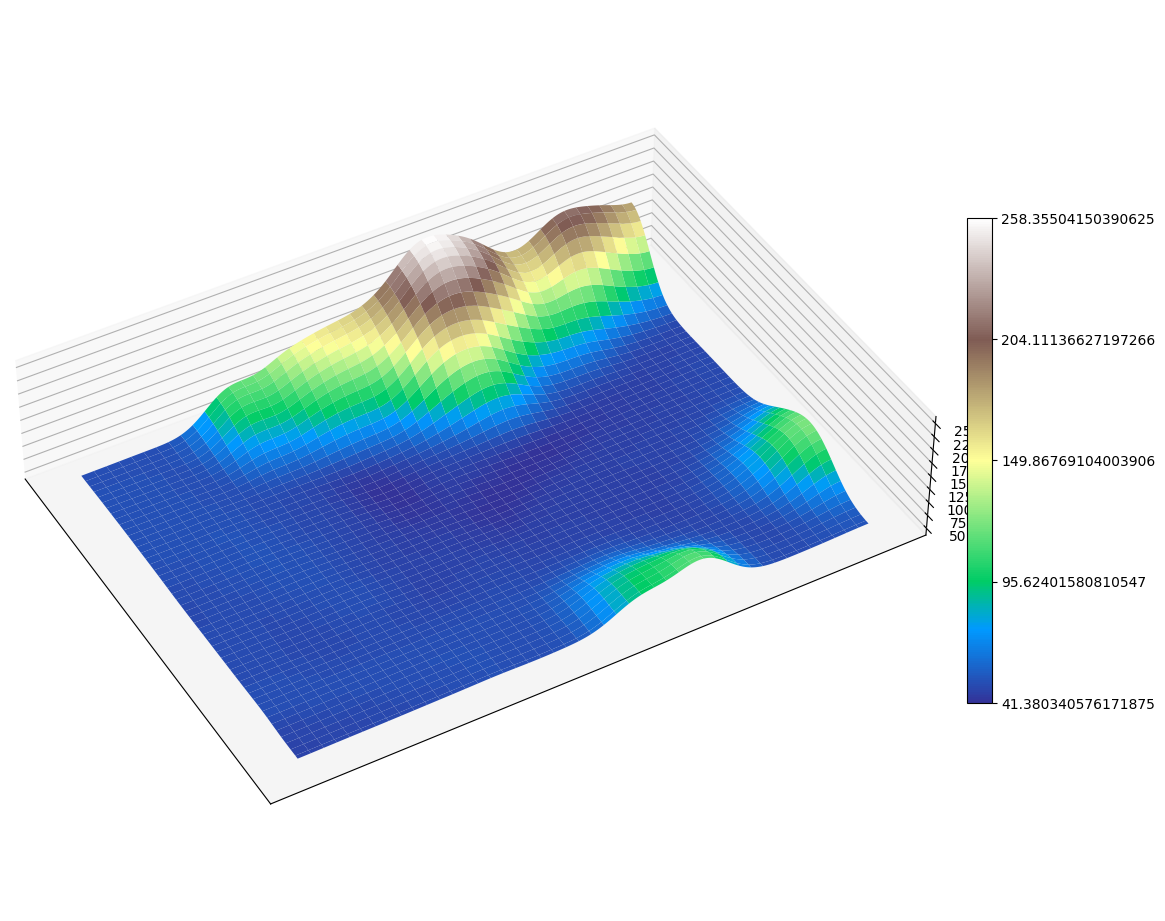

In [115]:

source_file_dem = 'terrain.tif'

# Set max number of pixel to: 'None' to prevent errors. Its not nice, but works for that case. Big images will load RAM+CPU heavily (like DecompressionBomb)
Image.MAX_IMAGE_PIXELS = None # first we set no limit to open
img = Image.open(source_file_dem)

# get aspect ratio of tif file for late plot box-plot-ratio
y_ratio,x_ratio = img.size

# open georeference TIF file
dem = gdal.Open(source_file_dem)
gt  = dem.GetGeoTransform()
dem_array = dem.ReadAsArray()

# create arrays and declare x,y,z variables
lin_x = np.linspace(0,1,dem_array.shape[0],endpoint=False)
lin_y = np.linspace(0,1,dem_array.shape[1],endpoint=False)
y,x = np.meshgrid(lin_y,lin_x)
z = dem_array

# Apply gaussian filter, with sigmas as variables. Higher sigma = more smoothing and more calculations. Downside: min and max values do change due to smoothing
sigma_y =10
sigma_x = 10
sigma = [sigma_y, sigma_x]
z_smoothed = sp.ndimage.gaussian_filter(z, sigma)

# Some min and max and range values coming from gaussian_filter calculations
z_smoothed_min = np.amin(z_smoothed)
z_smoothed_max = np.amax(z_smoothed)
z_range = z_smoothed_max - z_smoothed_min

# Creating figure
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection='3d')
ax.azim = -30
ax.elev = 42
ax.set_box_aspect((x_ratio,y_ratio,((x_ratio+y_ratio)/8)))
# ax.arrow3D(1,1,z_smoothed_max, -1,0,1, mutation_scale=20, ec ='black', fc='red') #draw arrow to "north" which is not correct north. But with georeferenced sources it should work
surf = ax.plot_surface(x,y,z_smoothed, cmap='terrain', edgecolor='none')
# setting colors for colorbar range
m = cm.ScalarMappable(cmap=surf.cmap, norm=surf.norm)
m.set_array(z_smoothed)
cbar = fig.colorbar(m, shrink=0.5, aspect=20, ticks=[z_smoothed_min, 0, (z_range*0.25+z_smoothed_min), (z_range*0.5+z_smoothed_min), (z_range*0.75+z_smoothed_min), z_smoothed_max])
cbar.ax.set_yticklabels([f'{z_smoothed_min}', ' ',  f'{(z_range*0.25+z_smoothed_min)}', f'{(z_range*0.5+z_smoothed_min)}', f'{(z_range*0.75+z_smoothed_min)}', f'{z_smoothed_max}'])
plt.xticks([])  # disabling xticks by Setting xticks to an empty list
plt.yticks([])  # disabling yticks by setting yticks to an empty list
# draw flat rectangle at z = 0 to indicate where mean sea level is in 3d
x_rectangle = [0,1,1,0]
y_rectangle = [0,0,1,1]
z_rectangle = [0,0,0,0]
verts = [list(zip(x_rectangle,y_rectangle,z_rectangle))]
# ax.add_collection3d(Poly3DCollection(verts, alpha=0.5))
fig.tight_layout()

plt.show()

In [82]:
ds = rxr.open_rasterio(filename='terrain.tif')
ds.sel(band=1)

<xarray.DataArray (y: 582, x: 825)>
[480150 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 3.602e+05 3.602e+05 ... 3.684e+05 3.684e+05
  * y            (y) float64 2.887e+06 2.887e+06 ... 2.893e+06 2.893e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              0.0
    scale_factor:            1.0
    add_offset:              0.0

[Plotting xarrays](https://docs.xarray.dev/en/latest/user-guide/plotting.html)

In [83]:
y_vals = ds.sel(band=1)['y'].values
x_vals = ds.sel(band=1)['x'].values

x = ds.sel(band=1)['x'].values
y = ds.sel(band=1)['y'].values
Z = ds.sel(band=1).values

print(x_vals.min()- x_vals.max())
print(y_vals.min()- y_vals.max())

-8240.0
-5810.0


In [118]:
fig = go.Figure()
fig.add_trace(go.Surface(z=z_smoothed, x=x, y=y))

# Set the box aspect ratio (equal scales for all axes)
fig.update_scenes(aspectratio=dict(x=5, y=5,z=1))
# Remove all margins

camera = dict(
    up=dict(x=0, y=0, z=1),
    eye=dict(x=1.25, y=1.25, z=1.25)
)

fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    scene_camera = camera
)

[Adjusting the figure aspect ratio in plotly](https://plotly.com/python/reference/layout/scene/#layout-scene-aspectratio)

## Visualize the results on interactive map

basemap options:
OpenTopoMap, Esri.WorldTopoMap

In [ ]:
## Choose the first image for visualizing the results
image_2000 = masked_image_collection.filter(ee.Filter.eq('year', 1995)).first()
isWaterImage = image_2000.selfMask()

Map = geemap.Map(basemap='OpenTopoMap')
visParams = {'palette': ['blue']}
Map.addLayer(isWaterImage.clip(geometry), visParams)
Map.centerObject(geometry, zoom=12)
Map

Map(center=[26.11995420853361, 91.64530222585796], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
isWaterImage

## Calculate the total area

Calculate the total surface water area based on whether or not the pixel is classified as water

In [ ]:
def getWaterSurfaceArea(image):

    areaImage = image.multiply(ee.Image.pixelArea())
    totalArea = areaImage.reduceRegion(
        reducer = ee.Reducer.sum(),
        geometry = geometry,
        scale=30,
        maxPixels = 1e10
    )

    totalArea = ee.Number(totalArea.get('waterClass')).divide(1e6).round()

    return image.set('area_km2', totalArea)

## Calculate the total area for all images:

There might be few images with 0 total area, maybe because there wasn't enough data for that area in that particular year

In [ ]:
## calculate the area of each image
areaImages = masked_image_collection.map(getWaterSurfaceArea)

In [ ]:
areaImages

## Extract the year and area values

After calculating the total area for all the image in the collection, extract the year and the total area property from each image for plotting:

In [ ]:
def extract_time_series(image_collection, stat='area_km2'):
    '''
    Extract timeseries values, the area values and corresponding the year
    '''

    image_list = image_collection.getInfo()['features']
    properties = [img['properties'] for img in image_list]

    xs, ys = [], []
    for prop in properties:
        x,y = prop['year'], prop[stat]
        xs.append(x), ys.append(y)

    return xs, ys

def plot_time_series(x,y):
    '''
    Plot the time series given the x - year, y - area for example
    and return a matplotlib figure
    '''

    fig,ax = plt.subplots(figsize=(15,3))
    ax.plot(x,y)
    ax.set_xlabel("Year")
    ax.set_ylabel('Surface Water Area (km2)')
    ax.set_title("Total Surface Water Area")
    ax.set_ylim(0,max(y)*1.3)
    ax.grid(axis = 'x')
    return fig

## Plotting the timeseries

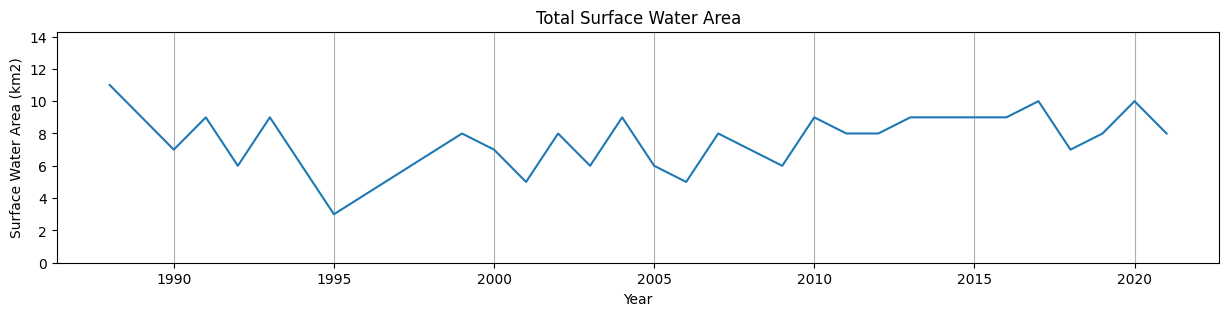

In [ ]:
xs,ys = extract_time_series(areaImages)
## Converting the data to a dataframe
df = pd.DataFrame(zip(xs,ys), columns=['year','area_km2'])

## Removing the null area values
df = df[df['area_km2']>0]

## plotting
fig = plot_time_series(df['year'],df['area_km2'])

In [ ]:
fig.savefig('water_surface_area.png', bbox_inches='tight')

There was no data found in the initial years due to lack of image data present for this location. Maybe because of lower temporal resolution in those years.

## Create a GIF of the timeseries

## Create the GIF using `.getVideoThumbURL()`

In [ ]:
## Remove images with 0 area
image_collection = areaImages.filter(ee.Filter.gt('area_km2',0))

## Visualization parameters
visParams = {
    'bands': 'waterClass',
    'palette': ['blue']
}

## Create the image visuals
images = image_collection.map(lambda image: image.visualize(min=0, max=1, palette=['black','blue']).selfMask())

## Define GIF visualization parameters.
gifParams = {
  'region': geometry,
  'dimensions': 600,
  'framesPerSecond': 1
}

## Download the gif
url = images.getVideoThumbURL(gifParams)
subprocess.run(["wget", url, "-O", "surface_water.gif"])

CompletedProcess(args=['wget', 'https://earthengine.googleapis.com/v1/projects/kavyajeetbora-ee/videoThumbnails/baa8007db839a8f2162c562e8bbf6e8b-52967fcb2730e6f73be8cc02d41a8e7a:getPixels', '-O', 'surface_water.gif'], returncode=0)

### Modify each frame and add title

Here using PIL python package to modify the image to add a label to it

Download any desired font type in `.ttf` file format:

More fonts available here: [
Adobe Fonts](https://github.com/adobe-fonts)

In [ ]:
!wget https://github.com/adobe-fonts/source-sans/raw/release/TTF/SourceSans3-Black.ttf -O SourceSans3-Black.ttf

--2024-05-24 06:31:29--  https://github.com/adobe-fonts/source-sans/raw/release/TTF/SourceSans3-Black.ttf
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/adobe-fonts/source-sans/release/TTF/SourceSans3-Black.ttf [following]
--2024-05-24 06:31:29--  https://raw.githubusercontent.com/adobe-fonts/source-sans/release/TTF/SourceSans3-Black.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 422244 (412K) [application/octet-stream]
Saving to: ‘SourceSans3-Black.ttf’

SourceSans3-Black.t 100%[===================>] 412.35K  --.-KB/s    in 0.03s   

2024-05-24 06:31:29 (13.3 MB/s) - ‘SourceSans3-Black.tt

In [ ]:
def label_gif_images(gif_file, labels, font_size=30):

    '''
    Input: gif file and list of labels
    Note: List of labels must be equal to the no. of frames in the gif file

    Saves the modified gif as 'new.gif` file
    '''
    gifImage = Image.open(gif_file) ## Read the gif file
    images = [] ## List to store the modified images

    for frame, label in zip(ImageSequence.Iterator(gifImage), labels):
        frame_image = frame.copy()
        canvas = ImageDraw.Draw(frame_image)

        # Custom font style and font size
        font = ImageFont.truetype('SourceSans3-Black.ttf', font_size)

        # Add Text to an image
        w,h = gifImage.size
        txt_x, txt_y = int(0.5*w), int(0.01*h)
        canvas.text((txt_x, txt_y), f"Year: {label}", fill =(255, 0, 0), align ="center", font=font)
        images.append(frame_image)

    ## Save the gif as a new file
    images[0].save(f"new.gif", append_images=images[1:], save_all=True)

[Reference for the above code](https://stackoverflow.com/a/63768149/6819442)

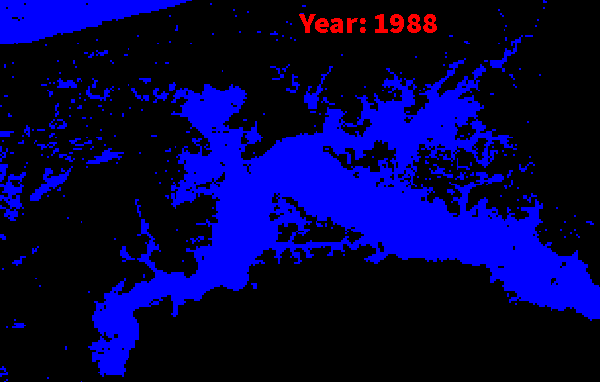

In [ ]:
label_gif_images("surface_water.gif", df.year)
IpyImage("new.gif")

## Create animation gif using geemap

This is the recommended Way

Reference
1. [Adding animated text to GIF images generated from Earth Engine data](https://giswqs.medium.com/16-adding-animated-text-to-gif-images-generated-from-earth-engine-data-b393c6332d2f)

In [ ]:
geemap.add_text_to_gif

<function geemap.timelapse.add_text_to_gif(in_gif, out_gif, xy=None, text_sequence=None, font_type='arial.ttf', font_size=20, font_color='#000000', add_progress_bar=True, progress_bar_color='white', progress_bar_height=5, duration=100, loop=0)>

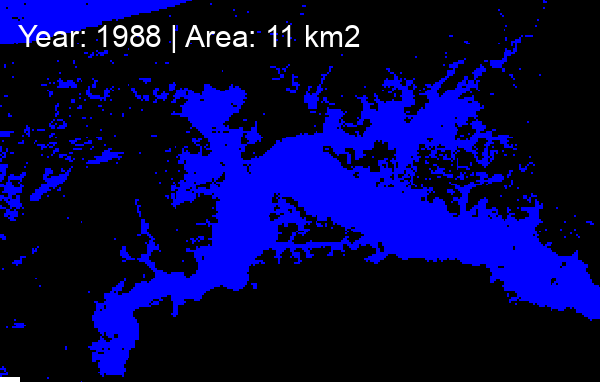

In [ ]:
text_sequence=[f"Year: {i[1]['year']} | Area: {i[1]['area_km2']} km2" for i in df.iterrows()]
new_file_name = "new_surface_water.gif"

geemap.add_text_to_gif(
    "surface_water.gif",
    new_file_name,
    xy=("3%", "5%"),
    text_sequence=text_sequence,
    font_size=30,
    font_color="#ffffff",
    duration=1000
)

IpyImage(filename='new_surface_water.gif')

Alternatively we can use `geemap.Map.add_time_slider`

```python
Map = geemap.Map()

vis_params = {'min': 0, 'max': 1, 'palette': ['#ece7f2','#a6bddb','#2b8cbe']}

Map.add_time_slider(areaImages.select('waterClass'), vis_params, labels=list(map(str,xs)), time_interval=1)
Map.centerObject(geometry, zoom=12)
Map
```

## References

1. [Calculating area in google earth engine](https://spatialthoughts.com/2020/06/19/calculating-area-gee/)
2. [Module2: Calculating the surface water mapping](https://courses.spatialthoughts.com/gee-water-resources-management.html#module-2-surface-water-mapping)